In [6]:
import numpy as np
import copy
import os
import pickle
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Sequential

class QLearner():
    # load in simulator, initialize global variables
    def __init__(self,simulator,savename,**kwargs):
        # make simulator global
        self.simulator = simulator
        
        # Q learn params
        self.explore_val = 1
        self.explore_decay = 0.99
        self.num_episodes = 500        
        self.gamma = 1
        
        if "gamma" in kwargs:   
            self.gamma = args['gamma']
        if 'explore_val' in kwargs:
            self.explore_val = kwargs['explore_val']
        if 'explore_decay' in kwargs:
            self.explore_decay = kwargs['explore_decay']
        if 'num_episodes' in kwargs:
            self.num_episodes = kwargs['num_episodes']
            
        # other training variables
        self.num_actions = self.simulator.action_space.n
        state = self.simulator.reset()    
        self.state_dim = np.size(state)
        self.training_reward = []
        
        # setup memory params
        self.memory_length = 2000    # length of memory replay
        self.replay_length = 200     # length of replay sample
        self.memory_start = 1000
        self.memory = []
        if 'memory_length' in kwargs:
            self.memory_length = kwargs['memory_length']
        if 'replay_length' in kwargs:
            self.replay_length = kwargs['replay_length']
        if 'memory_start' in kwargs:
            self.memory_start = kwargs['memory_start']
        
        ### initialize logs ###
        # create text file for training log
        self.logname = 'training_logs/' + savename + '.txt'
        self.reward_logname = 'reward_logs/' + savename + '.txt'
        self.weight_name = 'saved_model_weights/' + savename + '.pkl' 
        self.model_name = 'models/' + savename + '.json'

        self.init_log(self.logname)
        self.init_log(self.reward_logname)
        self.init_log(self.weight_name)
        self.init_log(self.model_name)
     
    ##### logging functions #####
    def init_log(self,logname):
        # delete log if old version exists
        if os.path.exists(logname): 
            os.remove(logname)
            
    def update_log(self,logname,update):
        if type(update) == str:
            logfile = open(logname, "a")
            logfile.write(update)
            logfile.close() 
        else:
            weights = []
            if os.path.exists(logname):
                with open(logname,'rb') as rfp: 
                    weights = pickle.load(rfp)
            weights.append(update)

            with open(logname,'wb') as wfp:
                pickle.dump(weights, wfp)
    
    ##### functions for creating / updating Q #####
    def initialize_Q(self,**kwargs):
        # default parameters for network
        layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        loss = 'mse'
        lr = 10**(-2)
        if 'alpha' in kwargs:
            lr = kwargs['alpha']
        optimizer = RMSprop(lr = lr,clipnorm = 1)        

        # input / output sizes of network
        input_dim = self.state_dim
        output_dim = self.num_actions

        # build model based on parameters
        self.model = Sequential()

        # add input layer
        self.model.add(Dense(layer_sizes[0], input_dim=input_dim, activation=activation))

        # add hidden layers
        for U in layer_sizes[1:]:
            self.model.add(Dense(U,activation=activation))

        # add output layer
        self.model.add(Dense(output_dim, activation='linear'))

        # chose optimizer and its associated parameters
        self.model.compile(loss=loss, optimizer=optimizer)
        
        # initialize Q
        self.Q = self.model.predict
        
        # since its easy to save models with keras / tensorflow, save to file
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
            json_file.write(model_json)

    # update Q function
    def update_Q(self,state,next_state,action,reward,done):
        # add newest sample to queue
        self.update_memory(state,next_state,action,reward,done)
        
        # only update Q if sufficient memory has been collected
        if len(self.memory) < self.memory_start:
            return
        
        # update memory sample
        self.sample_memory()
        
        # generate q_values based on most recent Q
        q_vals = []
        states = []
        for i in range(len(self.replay_samples)):    
            # get sample
            sample = self.replay_samples[i]
            
            # strip sample for parts
            state = sample[0]
            next_state = sample[1]
            action = sample[2]
            reward = sample[3]
            done = sample[4]
                            
            ### for cartpole only - check if done, and alter reward to improve learning ###
            done,reward = self.check_done(done,reward)

            # compute and store q value
            q = reward 
            if done == False:
                qs = self.Q(next_state)
                q += self.gamma*np.max(qs)
            
            # clamp all other models to their current values for this input/output pair
            q_update = self.Q(state).flatten()
            q_update[action] = q
            q_vals.append(q_update)
            states.append(state.T)
            
        # convert lists to numpy arrays for regressor
        s_in = np.array(states).T
        q_vals = np.array(q_vals).T
        s_in = s_in[0,:,:]
                            
        # take descent step
        num_pts = s_in.shape[1]
        self.model.fit(x=s_in.T,y=q_vals.T,batch_size=num_pts, epochs=1,verbose = 0)
        
        # update Q based on regressor updates
        self.Q = self.model.predict
        
    ##### functions for adjusting replay memory #####
    # update memory - add sample to list, remove oldest samples 
    def update_memory(self,state,next_state,action,reward,done):
        # add most recent trial data to memory
        self.memory.append([state,next_state,action,reward,done])

        # clip memory if it gets too long    
        num_elements = len(self.memory)
        if num_elements >= self.memory_length:    
            num_delete = num_elements - self.memory_length
            self.memory[:num_delete] = []
    
    # sample from memory and create input / output pairs for regression
    def sample_memory(self):
        # indices to sample
        memory_num = len(self.memory)
        sample_nums = np.random.permutation(memory_num)[:self.replay_length]
        
        # create samples
        self.replay_samples = [self.memory[v] for v in sample_nums]
    
    ##### Q Learning functionality #####
    # special function to check done
    def check_done(self,done,reward):
        if done == True:
            reward = -100
        return done,reward
    
    # state normalizer
    def state_normalizer(self,states):
        states = np.array(states)[np.newaxis,:]
        return states
    
    # choose next action
    def choose_action(self,state):
        # pick action at random
        p = np.random.rand(1)   
        action = np.random.randint(self.num_actions)
            
        # pick action based on exploiting
        if len(self.memory) >= self.memory_start:
            qs = self.Q(state) 
            if p > self.explore_val:
                action = np.argmax(qs)
        return action
    
    # main training function
    def train(self,**kwargs):        
        ### start main Q-learning loop ###
        for n in range(self.num_episodes): 
            # pick this episode's starting position - randomly initialize from f_system
            state = self.simulator.reset()    
            state = self.state_normalizer(state)
            total_episode_reward = 0
            done = False
            
            # get out exploit parameter for this episode
            if self.explore_val > 0.01:
                self.explore_val *= self.explore_decay
                    
            # run episode
            step = 0
            while done == False and step < 500:    
                # choose next action
                action = self.choose_action(state)
    
                # transition to next state, get associated reward
                next_state,reward,done,info = self.simulator.step(action)  
                next_state = self.state_normalizer(next_state)
                
                # update Q function
                self.update_Q(state,next_state,action,reward,done)  

                # update total reward from this episode
                total_episode_reward+=reward
                state = copy.deepcopy(next_state)
                step+=1
                  
            # start storing once memory is full 
            if len(self.memory) >= self.memory_start:
                # print out update if verbose set to True
                update = 'training episode ' + str(n+1) +  ' of ' + str(self.num_episodes) + ' complete, ' +  ' explore val = ' + str(np.round(self.explore_val,3)) + ', episode reward = ' + str(np.round(total_episode_reward,2)) 

                self.update_log(self.logname,update + '\n')
                print (update)

                update = str(total_episode_reward) + '\n'
                self.update_log(self.reward_logname,update)

                ### store this episode's computation time and training reward history
                self.training_reward.append(total_episode_reward)

                # save latest weights from this episode 
                update = self.model.get_weights()
                self.update_log(self.weight_name,update)
            
        ### save weights ###
        update = 'q-learning algorithm complete'
        self.update_log(self.logname,update + '\n')
        print (update)

# Run test

In [9]:
# imports
import gym

# savename
savename = 'lunar_lander_experiment_1'

# initialize simulator
simulator = gym.make('LunarLander-v2') 

# initialize Q Learn process
num_episodes = 500
explore_decay = 0.995
explore_val = 1

# initialize memory
replay_length = 100
memory_length = 1000

# load into instance of learner
demo = QLearner(simulator,savename,num_episodes=num_episodes,explore_decay=explore_decay,explore_val=explore_val,memory_length=memory_length,replay_length=replay_length)

# initialize Q function
layer_sizes = [50,50]
alpha = 10**(-2)
activation = 'relu'
demo.initialize_Q(layer_sizes=layer_sizes,alpha=alpha,activation=activation)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/joele119/Desktop/ml_class/Reinforce_hw_2_w_examples/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [10]:
demo.train()

training episode 12 of 500 complete,  explore val = 0.942, episode reward = -380.93
training episode 13 of 500 complete,  explore val = 0.937, episode reward = -458.29
training episode 14 of 500 complete,  explore val = 0.932, episode reward = -139.69
training episode 15 of 500 complete,  explore val = 0.928, episode reward = -390.34
training episode 16 of 500 complete,  explore val = 0.923, episode reward = -159.07
training episode 17 of 500 complete,  explore val = 0.918, episode reward = -254.4
training episode 18 of 500 complete,  explore val = 0.914, episode reward = -135.91
training episode 19 of 500 complete,  explore val = 0.909, episode reward = -162.82
training episode 20 of 500 complete,  explore val = 0.905, episode reward = -355.5
training episode 21 of 500 complete,  explore val = 0.9, episode reward = -171.74
training episode 22 of 500 complete,  explore val = 0.896, episode reward = -240.58
training episode 23 of 500 complete,  explore val = 0.891, episode reward = -285

training episode 110 of 500 complete,  explore val = 0.576, episode reward = -348.84
training episode 111 of 500 complete,  explore val = 0.573, episode reward = -323.58
training episode 112 of 500 complete,  explore val = 0.57, episode reward = -420.37
training episode 113 of 500 complete,  explore val = 0.568, episode reward = -382.69
training episode 114 of 500 complete,  explore val = 0.565, episode reward = -335.62
training episode 115 of 500 complete,  explore val = 0.562, episode reward = -402.58
training episode 116 of 500 complete,  explore val = 0.559, episode reward = -673.32
training episode 117 of 500 complete,  explore val = 0.556, episode reward = -244.95
training episode 118 of 500 complete,  explore val = 0.554, episode reward = -236.91
training episode 119 of 500 complete,  explore val = 0.551, episode reward = -344.41
training episode 120 of 500 complete,  explore val = 0.548, episode reward = -571.98
training episode 121 of 500 complete,  explore val = 0.545, episod

training episode 207 of 500 complete,  explore val = 0.354, episode reward = -679.02
training episode 208 of 500 complete,  explore val = 0.353, episode reward = -281.57
training episode 209 of 500 complete,  explore val = 0.351, episode reward = -775.39
training episode 210 of 500 complete,  explore val = 0.349, episode reward = -397.17
training episode 211 of 500 complete,  explore val = 0.347, episode reward = -229.47
training episode 212 of 500 complete,  explore val = 0.346, episode reward = -268.99
training episode 213 of 500 complete,  explore val = 0.344, episode reward = -408.35
training episode 214 of 500 complete,  explore val = 0.342, episode reward = -376.13
training episode 215 of 500 complete,  explore val = 0.34, episode reward = -157.32
training episode 216 of 500 complete,  explore val = 0.339, episode reward = -419.77
training episode 217 of 500 complete,  explore val = 0.337, episode reward = -325.49
training episode 218 of 500 complete,  explore val = 0.335, episod

training episode 304 of 500 complete,  explore val = 0.218, episode reward = -715.92
training episode 305 of 500 complete,  explore val = 0.217, episode reward = -1057.47
training episode 306 of 500 complete,  explore val = 0.216, episode reward = -526.5
training episode 307 of 500 complete,  explore val = 0.215, episode reward = -245.61
training episode 308 of 500 complete,  explore val = 0.214, episode reward = -682.89
training episode 309 of 500 complete,  explore val = 0.212, episode reward = -520.92
training episode 310 of 500 complete,  explore val = 0.211, episode reward = -617.9
training episode 311 of 500 complete,  explore val = 0.21, episode reward = -424.86
training episode 312 of 500 complete,  explore val = 0.209, episode reward = -469.79
training episode 313 of 500 complete,  explore val = 0.208, episode reward = -748.78
training episode 314 of 500 complete,  explore val = 0.207, episode reward = -618.08
training episode 315 of 500 complete,  explore val = 0.206, episode

training episode 401 of 500 complete,  explore val = 0.134, episode reward = -589.24
training episode 402 of 500 complete,  explore val = 0.133, episode reward = -388.93
training episode 403 of 500 complete,  explore val = 0.133, episode reward = -823.51
training episode 404 of 500 complete,  explore val = 0.132, episode reward = -334.77
training episode 405 of 500 complete,  explore val = 0.131, episode reward = -246.04
training episode 406 of 500 complete,  explore val = 0.131, episode reward = -1057.26
training episode 407 of 500 complete,  explore val = 0.13, episode reward = -484.43
training episode 408 of 500 complete,  explore val = 0.129, episode reward = -247.01
training episode 409 of 500 complete,  explore val = 0.129, episode reward = -491.28
training episode 410 of 500 complete,  explore val = 0.128, episode reward = -481.61
training episode 411 of 500 complete,  explore val = 0.127, episode reward = -815.05
training episode 412 of 500 complete,  explore val = 0.127, episo

training episode 498 of 500 complete,  explore val = 0.082, episode reward = -426.24
training episode 499 of 500 complete,  explore val = 0.082, episode reward = -557.42
training episode 500 of 500 complete,  explore val = 0.082, episode reward = -3594.55
q-learning algorithm complete


# plot total episode reward history

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_history(logname,**kwargs):
    # load in total episode reward history
    data = np.loadtxt(logname)
    ave = [data[v] for v in range(100)]
    
    for i in range(0,np.size(data)-100):
        m = np.mean(data[i:i+100])
        ave.append(m)
    
    # create figure
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot total reward history
    start = 0
    if 'start' in kwargs:
        start = kwargs['start']
    ax1.plot(data[start:])
    ax1.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax1.set_ylabel('total reward',fontsize = 13)
    
    ax2.plot(ave[start:],linewidth=3)
    ax2.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax2.set_ylabel('ave total reward',fontsize=13)
    plt.show()

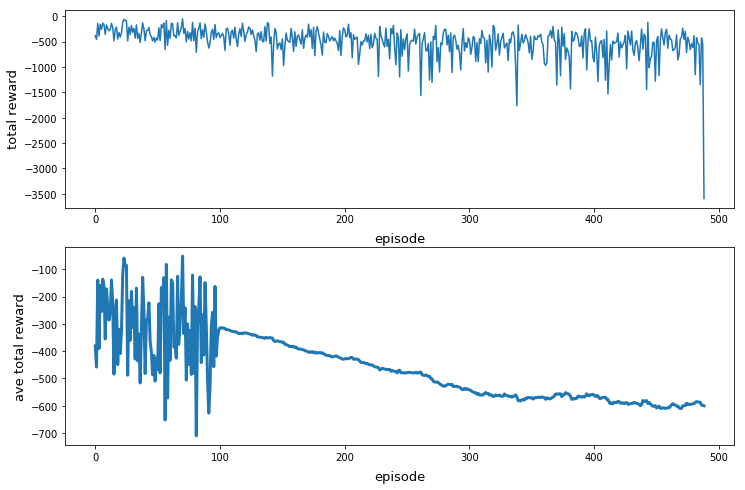

In [12]:
reward_logname = 'reward_logs/' + savename + '.txt'
plot_reward_history(reward_logname)